# Preamble

In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib
import scipy.io as sio

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Dropbox/Work/git/pyfunc/')
from func import mark_outliers, winsorize_outliers_signed

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude'
extra_str = '_consist' # '_vol_norm' '_noboxcox'
edge_weight = 'streamlineCount' # 'streamlineCount' 'fa' 'mean_streamlineLength' 'adc'
parc_scale = 200
primary_covariate = 'ageAtScan1_Years'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(exclude_str = exclude_str, train_test_str = train_test_str,
                                                                                        parc_scale = parc_scale, primary_covariate = primary_covariate,
                                                                                       extra_str = extra_str, edge_weight = edge_weight)

### Setup output directory

In [4]:
print(os.environ['MODELDIR'])
if not os.path.exists(os.environ['MODELDIR']): os.makedirs(os.environ['MODELDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis_cubic_test/normative/t1Exclude/squeakycleanExclude/schaefer_200_streamlineCount_consist


### Data processing options

In [5]:
wins_data = False
my_thresh = 3
norm_data = True

## Load data

In [6]:
# Load data
df = pd.read_csv(os.path.join(os.environ['MODELDIR'], 'df_pheno.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(1062, 46)


In [7]:
# Load data
df_node = pd.read_csv(os.path.join(os.environ['MODELDIR'], 'df_node_base.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)
print(df_node.shape)

(1062, 801)


In [8]:
df_node.head()

,,squeakycleanExclude,vol_0,vol_1,vol_2,vol_3,vol_4,vol_5,vol_6,vol_7,vol_8,...,mc_190,mc_191,mc_192,mc_193,mc_194,mc_195,mc_196,mc_197,mc_198,mc_199
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
81287,2738,0,5189.0,2500.0,2724.0,2812.0,3148.0,3396.0,2501.0,1817.0,843.0,...,0.959763,0.844990,0.927408,0.968814,0.994395,0.971797,0.966033,0.992555,0.982908,0.990543
80680,2739,1,6030.0,4159.0,4376.0,3968.0,4736.0,4269.0,4102.0,3579.0,1518.0,...,0.935903,0.873835,0.652250,0.784366,0.943377,0.918424,0.936248,0.977202,0.932814,0.975621
81754,2740,1,5426.0,3135.0,4029.0,3247.0,4108.0,3276.0,2612.0,2754.0,741.0,...,0.907625,0.983894,0.931573,0.913933,0.976324,0.969865,0.986134,0.997702,0.984583,0.995968
81903,2749,0,3173.0,2491.0,2027.0,2494.0,2450.0,3164.0,2554.0,1617.0,664.0,...,0.949130,0.983709,0.896786,0.953799,0.982359,0.958171,0.973325,0.996257,0.983886,0.994039
81043,2750,0,3327.0,1890.0,2183.0,2525.0,3189.0,2660.0,2451.0,1758.0,871.0,...,0.874115,0.981286,0.837727,0.952593,0.991303,0.967862,0.978795,0.995378,0.971681,0.986653


In [9]:
metrics = ('vol', 'str', 'ac', 'mc')
dwi_metrics = ('str', 'ac', 'mc')
t1_metrics = ('vol',)

### Compute whole brain averages

In [10]:
df_node_mean = pd.DataFrame(index = df_node.index, columns = metrics)
for metric in metrics:
    df_node_mean[metric] = df_node.filter(regex = metric, axis = 1).mean(axis = 1)

# Plots

In [11]:
# Labels
sns.set(style='white', context = 'talk', font_scale = 1)

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


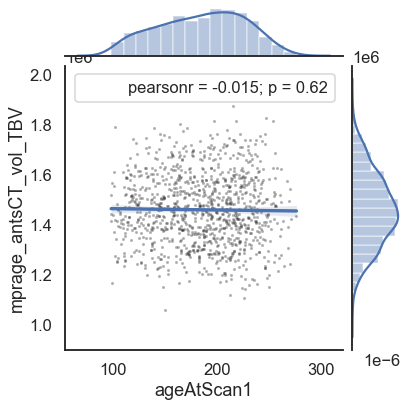

In [12]:
metric_x = 'ageAtScan1'
metric_y = 'mprage_antsCT_vol_TBV'
f = sns.jointplot(x = df[metric_x], y = df[metric_y], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


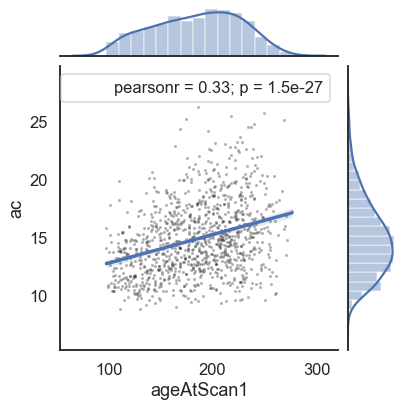

In [13]:
metric_x = 'ageAtScan1'
metric_y = 'ac'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


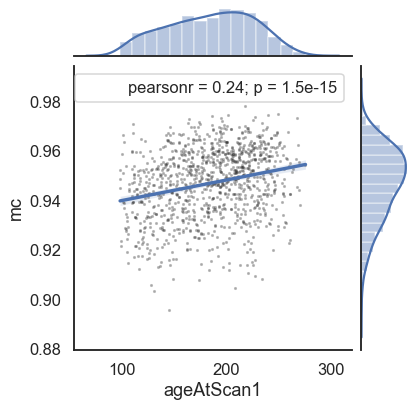

In [14]:
metric_x = 'ageAtScan1'
metric_y = 'mc'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [15]:
metric_x = 'mprage_antsCT_vol_TBV'
# metric_x = 'network_density'
# metric_x = 'streamline_count'

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


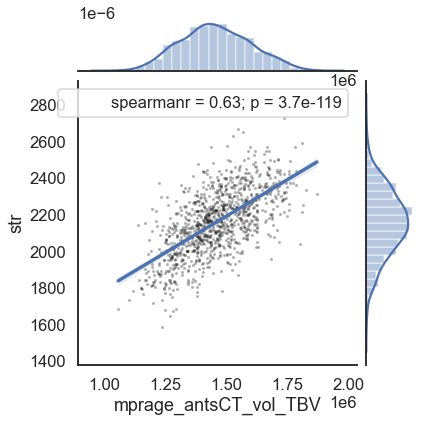

In [16]:
metric_y = 'str'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


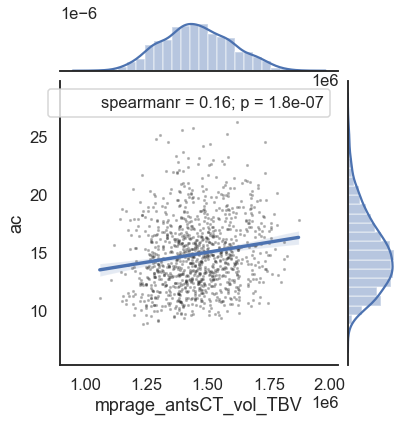

In [17]:
metric_y = 'ac'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


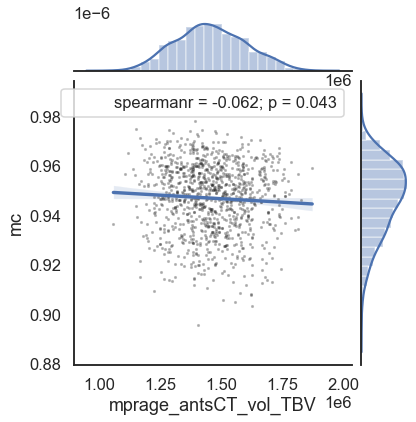

In [18]:
metric_y = 'mc'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [19]:
for metric in dwi_metrics:
    x = df_node.filter(regex = metric, axis = 1).mean(axis = 1)
    outliers = mark_outliers(x, thresh = my_thresh)
    print(metric + ': ' + str(np.round((outliers.sum() / x.shape[0]) * 100,2)))

str: 18.08
ac: 15.44
mc: 14.88


A higher threshold than 3 probably makes sense but sticking with convention to avoid 'kick me' signs with reviewers.

Note, results are unaffected by setting my_thresh to 4,5, or 6

### Check frequency of outliers

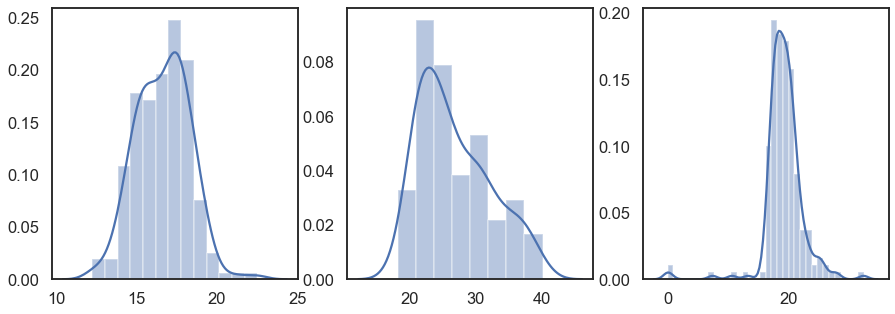

In [20]:
df_node_mask = pd.DataFrame(index = df_node.index, columns = df_node.columns)
for i, col in enumerate(df_node.columns):
    x = df_node.loc[:,col].copy()
    x_out = mark_outliers(x, thresh = my_thresh)
    df_node_mask.loc[:,col] = x_out

f, axes = plt.subplots(1,len(dwi_metrics))
f.set_figwidth(len(dwi_metrics)*5)
f.set_figheight(5)

for i, metric in enumerate(dwi_metrics):
    if df_node_mask.filter(regex = metric).sum().any():
        sns.distplot(df_node_mask.filter(regex = metric).sum()/df_node_mask.filter(regex = metric).shape[0]*100, ax = axes[i])

### Winsorize outliers

In [21]:
my_str = '|'.join(dwi_metrics); print(my_str)
# my_str = 'ac|mc'

str|ac|mc


In [22]:
if wins_data:
    for i, col in enumerate(df_node.filter(regex = my_str).columns):
        x = df_node.loc[:,col].copy()
        x_out = winsorize_outliers_signed(x, thresh = my_thresh)
        df_node.loc[:,col] = x_out
else:
    print('Skipping...')

Skipping...


## Normalize

In [23]:
if np.any(df_node < 0):
    print('WARNING: some regional values are <0, box cox will fail')

if np.any(df_node.drop(train_test_str, axis = 1) == 0):
    print('WARNING: some regional values are == 0, box cox will fail')

In [24]:
rank_r = np.zeros(df_node.filter(regex = my_str).shape[1])

# normalise
if norm_data:
    for i, col in enumerate(df_node.filter(regex = my_str).columns):
        # normalize regional metric
        x = sp.stats.boxcox(df_node.loc[:,col])[0]
        # check if rank order is preserved
        rank_r[i] = sp.stats.spearmanr(df_node.loc[:,col],x)[0]
        # store normalized version
        df_node.loc[:,col] = x
    np.sum(rank_r < .99)
else:
    print('Skipping...')

In [25]:
# my_str = 'ac|mc'

In [26]:
# rank_r = np.zeros(df_node.filter(regex = my_str).shape[1])

# # normalise
# if norm_data:
#     for i, col in enumerate(df_node.filter(regex = my_str).columns):
#         # normalize regional metric
#         x = sp.stats.yeojohnson(df_node.loc[:,col] + df_node.loc[:,col].abs().max())[0]
#         # check if rank order is preserved
#         rank_r[i] = sp.stats.spearmanr(df_node.loc[:,col],x)[0]
#         # store normalized version
#         df_node.loc[:,col] = x
# else:
#     print('Skipping...')

# np.sum(rank_r < .99)

### Check distributions

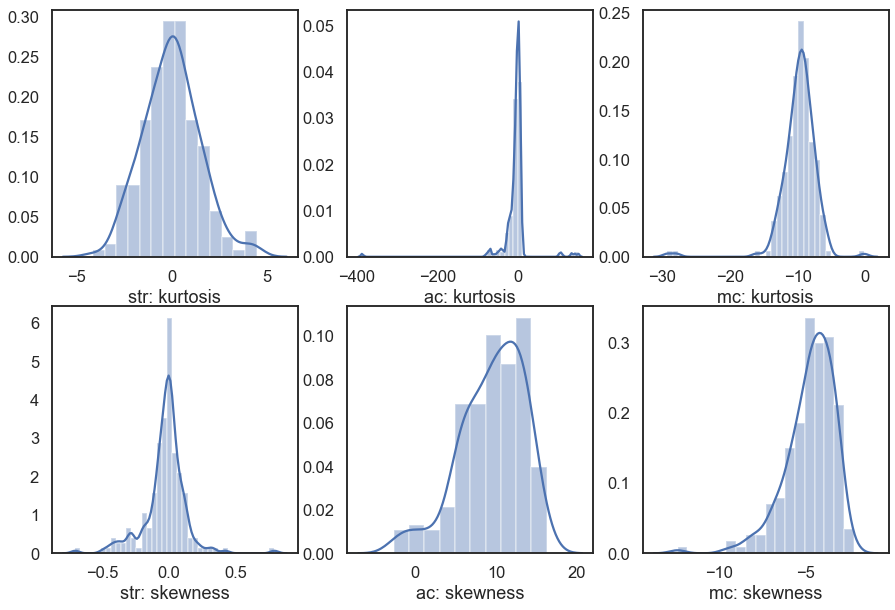

In [27]:
f, axes = plt.subplots(2,len(dwi_metrics))
f.set_figwidth(len(dwi_metrics)*5)
f.set_figheight(10)

for i, metric in enumerate(dwi_metrics):
    kur = np.zeros((df_node.filter(regex = metric).shape[1]))
    skew = np.zeros((df_node.filter(regex = metric).shape[1]))
    for j, node in enumerate(df_node.filter(regex = metric).columns):
        d = sp.stats.zscore(df_node.filter(regex = metric).loc[:,node])
        kur[j] = sp.stats.kurtosistest(d)[0]
        skew[j] = sp.stats.skewtest(d)[0]
    
    sns.distplot(kur, ax = axes[0,i])
    axes[0,i].set_xlabel(metric+': kurtosis')
    sns.distplot(skew, ax = axes[1,i])
    axes[1,i].set_xlabel(metric+': skewness')

In [28]:
# my_str = os.environ['MODELDIR'].split('/')[-1]
# my_str = my_str.split('_')[-1]
# my_str

In [29]:
# if my_str == 'nuis-streamline' or my_str == 'nuis-netdens':
#     df_node = df_node.filter(regex = 'squeakycleanExclude|str|ac|mc', axis = 1)
# elif my_str == 'nuis-str':
#     df_str = df_node.filter(regex = 'str', axis = 1).copy()
#     df_node = df_node.filter(regex = 'squeakycleanExclude|ac|mc', axis = 1)
# else:
#     print('skipping...')

In [30]:
# df_node.shape

## Nuisance regression

In [31]:
# df_node_bak = df_node.copy()

In [32]:
# # labels of nuisance regressors
# nuis = ['averageManualRating']
# print(nuis)
# df_nuis = df[nuis]
# df_nuis = sm.add_constant(df_nuis)

# my_str = '|'.join(t1_metrics); print(my_str)
# cols = df_node.filter(regex = my_str, axis = 1).columns

# mdl = sm.OLS(df_node.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
# y_pred = mdl.predict(df_nuis)
# y_pred.columns = cols
# df_node.loc[:,cols] = df_node.loc[:,cols] - y_pred

In [33]:
# if my_str == 'nuis-str':
#     print('Running strength nuisance regression')
#     for col in df_node.filter(regex = 'ac|mc', axis = 1).columns:
#         nuis = ['mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']
#         df_nuis = df[nuis]
#         df_nuis = sm.add_constant(df_nuis)

#         col_nuis = 'str_' + col.split('_')[1]
#         df_nuis.loc[:,'str'] = df_str.loc[:,col_nuis]

#         mdl = sm.OLS(df_node.loc[:,col], df_nuis).fit()
#         y_pred = mdl.predict(df_nuis)
#         df_node.loc[:,col] = df_node.loc[:,col] - y_pred
# else:
#     if my_str == 'nuis-netdens':
#         print('Running network density nuisance regression')
#         nuis = ['mprage_antsCT_vol_TBV', 'dti64MeanRelRMS', 'network_density']
#         df_nuis = df[nuis]
#     else:
#         print('Running standard nuisance regression')
#         nuis = ['mprage_antsCT_vol_TBV', 'dti64MeanRelRMS']
#         df_nuis = df[nuis]
#     print(nuis)
#     df_nuis = sm.add_constant(df_nuis)

#     my_str = '|'.join(dwi_metrics); print(my_str)
#     cols = df_node.filter(regex = my_str, axis = 1).columns

#     mdl = sm.OLS(df_node.loc[:,cols], df_nuis).fit()
#     y_pred = mdl.predict(df_nuis)
#     y_pred.columns = cols
#     df_node.loc[:,cols] = df_node.loc[:,cols] - y_pred

In [34]:
# r = np.zeros(df_node.shape[1])
# for i, col in enumerate(df_node.columns):
#     r[i] = sp.stats.spearmanr(df_node_bak[col],df_node[col])[0]
# sns.distplot(r)

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


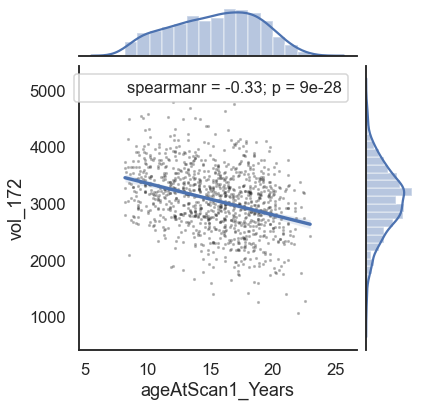

In [35]:
idx = df_node.filter(regex = 'vol').corrwith(df[primary_covariate]).abs().argmax()
f = sns.jointplot(x = df[primary_covariate], y = df_node['vol_'+str(idx)], kind="reg")
f.annotate(sp.stats.spearmanr)
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


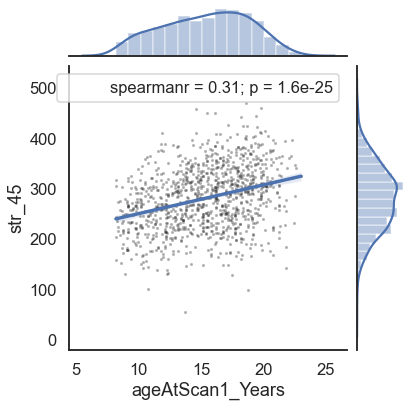

In [36]:
idx = df_node.filter(regex = 'str').corrwith(df[primary_covariate]).abs().argmax()
f = sns.jointplot(x = df[primary_covariate], y = df_node['str_'+str(idx)], kind="reg")
f.annotate(sp.stats.spearmanr)
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


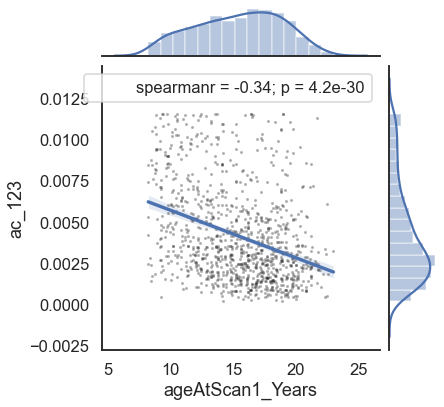

In [37]:
idx = df_node.filter(regex = 'ac').corrwith(df[primary_covariate]).abs().argmax()
f = sns.jointplot(x = df[primary_covariate], y = df_node['ac_'+str(idx)], kind="reg")
f.annotate(sp.stats.spearmanr)
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

/Users/lindenmp/opt/anaconda3/envs/neurodev_cs_predictive/lib/python3.7/site-packages/seaborn/axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


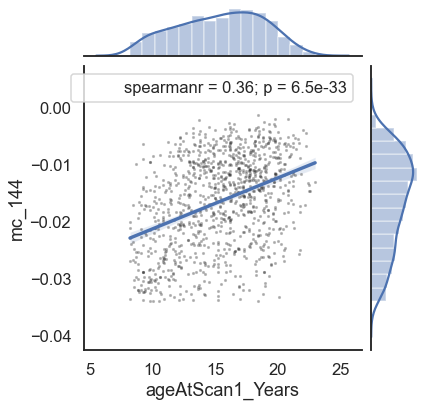

In [38]:
idx = df_node.filter(regex = 'mc').corrwith(df[primary_covariate]).abs().argmax()
f = sns.jointplot(x = df[primary_covariate], y = df_node['mc_'+str(idx)], kind="reg")
f.annotate(sp.stats.spearmanr)
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [39]:
df_node.isna().any().any()

False

## Save out

In [40]:
# Save out
df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node_clean.csv'))
# df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node_clean_my_thresh-'+str(my_thresh)+'.csv'))